#### Getting Started with FashionMNIST

This notebook shows how to load the FashionMNIST dataset in PyTorch and illustrates what kind of samples it contains.

In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm import tqdm
#from utils.dice_score import multiclass_dice_coeff, dice_coeff

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

# Transformationen definieren
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalisiert Daten auf [-1, 1]
])

# Erstellen Sie eine Instanz des Trainingssplits des FashionMNIST-Datasets
dataset_train = FashionMNIST(root='/data/FashionMNIST', train=True, download=True, 
                             transform=transform, target_transform=lambda x: torch.Tensor([x]).int())

# Jetzt erstellen Sie eine Instanz des Testsplits
dataset_valid = FashionMNIST(root='/data/FashionMNIST', train=False, download=True, 
                             transform=transform, target_transform=lambda x: torch.Tensor([x]).int())

# Für unsere Zwecke können wir die 60k Training- und 10k Testbeispiele kombinieren
from torch.utils.data import ConcatDataset
dataset = ConcatDataset([dataset_train, dataset_valid])

# Einige Informationen zum Datensatz anzeigen
print(f'The combined dataset contains {len(dataset)} samples.')
print(f'It contains objects from the following {len(dataset_train.classes)} classes:')
print(dataset_train.classes, '\n')
# select a random sample index and load the corresponding data sample
sample_idx = random.randrange(len(dataset))
# 
img_tensor, class_label = dataset.__getitem__(sample_idx)
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=256,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(dataset_valid, batch_size=256,
                                       shuffle=True, num_workers=2)



print('The shape of an image tensor is:', img_tensor.shape)
print('The shape of a class label is:', class_label.shape)

Using device cuda
The combined dataset contains 70000 samples.
It contains objects from the following 10 classes:
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] 

The shape of an image tensor is: torch.Size([1, 28, 28])
The shape of a class label is: torch.Size([1])


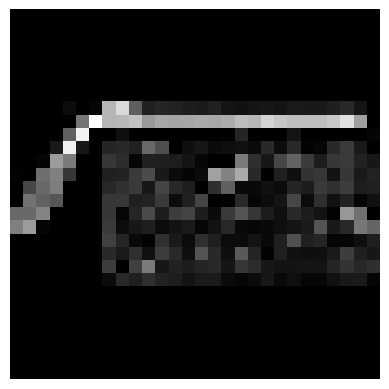

The image shows an instance of Bag.


In [3]:
# we can also visualize and describe a sample
fig, ax = plt.subplots()
ax.imshow(img_tensor.cpu().squeeze(), cmap='Greys_r')
plt.axis('off')
plt.show()
print('The image shows an instance of ' + dataset_train.classes[class_label.item()] + '.')

In [4]:
min_value = torch.min(img_tensor)
max_value = torch.max(img_tensor)

print(f"Minimaler Wert: {min_value.item()}")
print(f"Maximaler Wert: {max_value.item()}")



Minimaler Wert: -1.0
Maximaler Wert: 1.0


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



class ResidualBlock(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv2 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

        #self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        #self.fc1 = nn.Linear(128 * 4, 128)
        #self.fc2 = nn.Linear(128, 84)
        #self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        #x = self.fc1(x)
        #x = self.relu(x)
        #x = self.fc2(x)
        #x = self.relu(x)
        #x = self.fc3(x)
        

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)



In [6]:
# handvoll resisdual basic blocks -> flatten -> handvoll fully conntected layers
# resnet basic block : conv3x3 + norm_layer + non_lin + conv3x3 + normlayer
# identity: conv1x1 + norm layer
# output: non_lin(identity_layers(x) + [conv3x3 + norm_layer + non_lin + conv3x3 + normlayer](x))

In [7]:
def create_linear_schedule(steps, start, end):
    step_size = (end - start) / (steps - 1)  
    linear_schedule = []
    for i in range(steps):
        linear_schedule.append(start + i * step_size)
    return linear_schedule



In [8]:
def normalize_image(image):
    min_value = torch.min(image)
    max_value = torch.max(image)
    
    normalized_image = 2 * ((image - min_value) / (max_value - min_value)) - 1
    return normalized_image

In [9]:
# Function to add Gaussian noise to an image tensor
def add_gaussian_noise(image, mean=0., std=1.):
    eps = torch.empty_like(image).normal_(mean=0,std=1)
    noise = eps * std + mean
    # beta*eps + sqrt(1-beta)*image+std # (1-beta).sqrt()*image + beta*eps
    # Clip the values to be between 0 and 1
    # noisy_image = normalize_image(noisy_image)
    return noise, eps

In [10]:
def one_forward_step(curr_image, beta):
    std = np.sqrt(beta) #* np.random.normal()#* np.identity(like=curr_image) Nicht notwendig da äquivalent zu Skalar von Rechts
    mean = np.sqrt(1-beta) * curr_image #+ std
    image, eps = add_gaussian_noise(curr_image,mean=mean,std=std)
    return image

In [11]:
def mache_noise(image, anzahl_bilder):
    # Convert the image to a PyTorch tensor
    # transform = transforms.ToTensor()
    # image_tensor = transform(image)
    
    # Display the original image
    plt.imshow(image.cpu().squeeze())
    plt.title("Original Image")
    plt.show()
    
    verrauschte_bilder = []
    schedule = create_linear_schedule(anzahl_bilder, 0.0001, 0.02)
    print(schedule)
    noisy_image_tensor = image
    for i in range(len(schedule)):
        noisy_image_tensor = one_forward_step(noisy_image_tensor, schedule[i])
        
        # Convert the noisy image tensor back to a PIL image
        noisy_image = ((noisy_image_tensor/2)+0.5).cpu().squeeze()
        
        verrauschte_bilder.append(noisy_image)
        
        # Optional: Display each noisy image if desired
        plt.imshow(noisy_image, cmap='Greys_r')
        plt.title(f"Noisy Image {i+1}: {noisy_image_tensor.mean()}, {noisy_image_tensor.std()}")
        plt.show()
    

In [12]:
def berechne_alpha_quer_x_forward_steps(anzahl_steps):
    scheduler = create_linear_schedule(anzahl_steps, 0.0001, 0.02)
    alphas = 1 - np.array(scheduler)
    alphas_quer = []
    for i in range(len(alphas)):
        alphas_quer.append(np.prod(alphas[:i + 1]))
    return alphas_quer

In [13]:
def x_forward_steps(curr_image, alpha_quer):
    alpha_quer = torch.tensor(alpha_quer, dtype=torch.float32).to(device)  # 'device' is your CUDA device
    std = torch.sqrt(1 - alpha_quer)
    mean = torch.sqrt(alpha_quer) * curr_image
    new_image, eps = add_gaussian_noise(curr_image,mean=mean,std=std)
    return new_image, eps

In [14]:
def mache_noise_direkt(image, anzahl_steps, total_steps=1000):
    # Convert the image to a PyTorch tensor
    # transform = transforms.ToTensor()
    # image_tensor = transform(image)
    
    noisy_image_tensor = image
    
    alpha_quer = berechne_alpha_quer_x_forward_steps(total_steps)
    
    noisy_image_tensor, eps = x_forward_steps(noisy_image_tensor, alpha_quer[anzahl_steps-1])
    noisy_image = ((noisy_image_tensor/2)+0.5).cpu().squeeze()
    
    return noisy_image_tensor, eps


In [15]:
def mache_noise_direkt_random(batch_images, total_steps=1000, device=device):
    # Verschieben Sie den Batch auf die GPU
    batch_images = batch_images.to(device)
    
    # Annahme: batch_images hat die Form [batch_size, channels, height, width]
    batch_size = batch_images.size(0)
    
    alpha_quer_list = berechne_alpha_quer_x_forward_steps(total_steps)
    alpha_quer = torch.tensor(alpha_quer_list, device=device)

    noisy_batch = []
    epsilons = []
    anzahl_steps_array = np.empty(batch_size)
    # for loop vernichten
    for i in range(batch_size):
        anzahl_steps = np.random.randint(total_steps)
        anzahl_steps_array[i] = anzahl_steps
        
        image = batch_images[i]
        noisy_image, eps = x_forward_steps(image.unsqueeze(0).to(device), alpha_quer[anzahl_steps-1])  # Verschieben auf die GPU
        
        noisy_batch.append(noisy_image)
        epsilons.append(eps)
    
    noisy_batch_tensor = torch.cat(noisy_batch, dim=0).to(device)  # Verschieben auf die GPU
    epsilons_tensor = torch.cat(epsilons, dim=0).to(device)  # Verschieben auf die GPU
    
    return noisy_batch_tensor, epsilons_tensor, anzahl_steps_array


In [16]:
import torch.nn as nn

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
            
        )

    def forward(self, x):
        return self.double_conv(x)


In [17]:
class DownStride(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [18]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            #nn.MaxPool2d(2),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.LeakyReLU(inplace=True),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [19]:
def leaky_relu_init(m, negative_slope=0.2):
    gain = np.sqrt(2.0 / (1.0 + negative_slope ** 2))
    if isinstance(m, torch.nn.Conv1d):
        ksize = m.kernel_size[0]
        n1 = m.in_channels
        n2 = m.out_channels

        std = gain * np.sqrt(2.0 / ((n1 + n2) * ksize))
    elif isinstance(m, torch.nn.Conv2d):
        ksize = m.kernel_size[0] * m.kernel_size[1]
        n1 = m.in_channels
        n2 = m.out_channels

        std = gain * np.sqrt(2.0 / ((n1 + n2) * ksize))
    elif isinstance(m, torch.nn.Conv3d):
        ksize = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2]
        n1 = m.in_channels
        n2 = m.out_channels

        std = gain * np.sqrt(2.0 / ((n1 + n2) * ksize))
    elif isinstance(m, torch.nn.ConvTranspose1d):
        ksize = m.kernel_size[0] // 2
        n1 = m.in_channels
        n2 = m.out_channels

        std = gain * np.sqrt(2.0 / ((n1 + n2) * ksize))
    elif isinstance(m, torch.nn.ConvTranspose2d):
        ksize = m.kernel_size[0] * m.kernel_size[1] // 4
        n1 = m.in_channels
        n2 = m.out_channels

        std = gain * np.sqrt(2.0 / ((n1 + n2) * ksize))
    elif isinstance(m, torch.nn.ConvTranspose3d):
        ksize = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] // 8
        n1 = m.in_channels
        n2 = m.out_channels

        std = gain * np.sqrt(2.0 / ((n1 + n2) * ksize))
    elif isinstance(m, torch.nn.Linear):
        n1 = m.in_features
        n2 = m.out_features

        std = gain * np.sqrt(2.0 / (n1 + n2))
    else:
        return

    # is_wnw = is_weight_norm_wrapped(m)
    # if is_wnw:
    #     m.fuse()

    m.weight.data.uniform_(-std * np.sqrt(3.0), std * np.sqrt(3.0))
    if m.bias is not None:
        m.bias.data.zero_()


    # blockwise initialization for transposed convs
    if isinstance(m, torch.nn.ConvTranspose2d):
        # hardcoded for stride=2 for now
        m.weight.data[:, :, 0::2, 1::2] = m.weight.data[:, :, 0::2, 0::2]
        m.weight.data[:, :, 1::2, 0::2] = m.weight.data[:, :, 0::2, 0::2]
        m.weight.data[:, :, 1::2, 1::2] = m.weight.data[:, :, 0::2, 0::2]

    if isinstance(m, torch.nn.ConvTranspose3d):
        # hardcoded for stride=2 for now
        m.weight.data[:, :, 0::2, 0::2, 1::2] = m.weight.data[:, :, 0::2, 0::2, 0::2]
        m.weight.data[:, :, 0::2, 1::2, 0::2] = m.weight.data[:, :, 0::2, 0::2, 0::2]
        m.weight.data[:, :, 0::2, 1::2, 1::2] = m.weight.data[:, :, 0::2, 0::2, 0::2]
        m.weight.data[:, :, 1::2, 0::2, 0::2] = m.weight.data[:, :, 0::2, 0::2, 0::2]
        m.weight.data[:, :, 1::2, 0::2, 1::2] = m.weight.data[:, :, 0::2, 0::2, 0::2]
        m.weight.data[:, :, 1::2, 1::2, 0::2] = m.weight.data[:, :, 0::2, 0::2, 0::2]
        m.weight.data[:, :, 1::2, 1::2, 1::2] = m.weight.data[:, :, 0::2, 0::2, 0::2]

    # if is_wnw:
        # m.unfuse()

def apply_weight_init_fn(m, fn, negative_slope=1.0):
    should_initialize_weight=True
    if not hasattr(m, "weights_initialized"): #if we don't have this then we need to intiialzie
        # fn(m, is_linear, scale)
        should_initialize_weight=True
    elif m.weights_initialized==False: #if we have it but it's set to false
        # fn(m, is_linear, scale)
        should_initialize_weight=True
    else:
        print("skipping weight init on ", m)
        should_initialize_weight=False

    if should_initialize_weight:
        # fn(m, is_linear, scale)
        fn(m,negative_slope)
        # m.weights_initialized=True
        for module in m.children():
            apply_weight_init_fn(module, fn, negative_slope)

In [20]:
# Comments inspired from https://distill.pub/2016/deconv-checkerboard/

#Stride 1 deconvolutions — which we often see as the last layer in successful models 
#(eg. [2])  — are quite effective at dampening artifacts. 
#In particular, deconvolution has uneven overlap when the kernel size 
#(the output window size) is not divisible by the stride (the spacing between points on the top).

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True))
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        #Diese Zeilen berechnen die Größenunterschiede
        #in den Höhen- und Breitenrichtungen zwischen x2 und dem upgesampleten x1.
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        #Diese Zeile fügt x1 an den Rändern Polster hinzu, 
        #sodass es die gleiche räumliche Größe wie x2 hat. Das 
        #Padding sorgt dafür, dass die beiden Feature-Maps aneinander angehängt werden können.

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [21]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [22]:
def get_sinusoid_encoding_table(n_position, d_hid):
    ''' Sinusoid position encoding table '''

    def get_position_angle_vec(position):
        return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

    sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    return torch.FloatTensor(sinusoid_table)#.unsqueeze(0)

In [23]:
def concat_pos_param(x, enc):
    if x.shape[0] == 1:
        pos_enc_reshape = enc[None,:,None,None].expand((-1,-1,x.shape[-2],x.shape[-1]))
        feature_map_with_encoding = torch.cat([x.to(device), pos_enc_reshape.to(device)], dim=1)
    else: 
        pos_enc_reshape = enc[:,:,None,None].expand((-1,-1,x.shape[-2],x.shape[-1]))
        feature_map_with_encoding = torch.cat([x.to(device), pos_enc_reshape.to(device)], dim=1)
    return feature_map_with_encoding

In [24]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, t_max=1000, d_hid=32, channels=[64,128,256,512,1024,2048]):
        super(UNet, self).__init__()
        assert len(channels) == 6
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        factor = 2
        self.pos_enc = nn.parameter.Parameter(get_sinusoid_encoding_table(t_max, d_hid), requires_grad=False)
        #self.pos_enc.requires_grad = False 
        self.inc = (DoubleConv(n_channels + d_hid, channels[0]))
        self.down1 = (Down(channels[0] + d_hid, channels[1]))
        self.down2 = (Down(channels[1] + d_hid, channels[2]))
        self.down3 = (Down(channels[2] + d_hid, channels[3]))
        self.down4 = (Down(channels[3] + d_hid, channels[4]))
        self.down5 = (Down(channels[4] + d_hid, channels[5]))
        self.up1 = (Up(channels[-1], channels[-2]))
        self.up2 = (Up(channels[-2], channels[-3]))
        self.up3 = (Up(channels[-3], channels[-4]))
        self.up4 = (Up(channels[-4], channels[-5]))
        self.up5 = (Up(channels[-5], channels[-6]))
        self.outc = (OutConv(channels[-6], n_channels))
        apply_weight_init_fn(self, leaky_relu_init, negative_slope=0.0)

    def forward(self, x, t):
        enc = self.pos_enc[t]
        #enc_reshape = enc[:,:,None,None].expand((-1,-1,x.shape[-2],x.shape[-1]))
        #enc = self.pos_enc[t]
        #print(torch.cat([x, enc_reshape],dim=1).shape)
        x1 = self.inc(concat_pos_param(x,enc))
        x2 = self.down1(concat_pos_param(x1, enc))
        x3 = self.down2(concat_pos_param(x2, enc))
        x4 = self.down3(concat_pos_param(x3, enc))
        x5 = self.down4(concat_pos_param(x4, enc))
        x6 = self.down5(concat_pos_param(x5, enc))
        #x7 = self.bottleneck(x7)
        #x4 = self.down3(x3)
        #x5 = self.down4(x4)
        #x = self.up1(x5, x4)
        
        x = self.up1(x6, x5)
        x = self.up2(x, x4)
        x = self.up3(x, x3)
        x = self.up4(x, x2)
        x = self.up5(x, x1)
        logits = self.outc(x)
        return logits
    

In [25]:
# LeakyRelu
unet = UNet(1,100)
unet = unet.to(device)
dataiter = iter(trainloader)
i, data = next(dataiter)
i = i.to(device)

In [26]:
unet.to(device)
B, H, W = 5, 28, 28
ts = torch.randint(0,1001, size=(B,)).long().to(device)
xs = torch.randn(size=(B,1,H,W)).to(device)
test = unet(xs, ts)
print(test.shape)

torch.Size([5, 1, 28, 28])


torch.Size([5, 32])


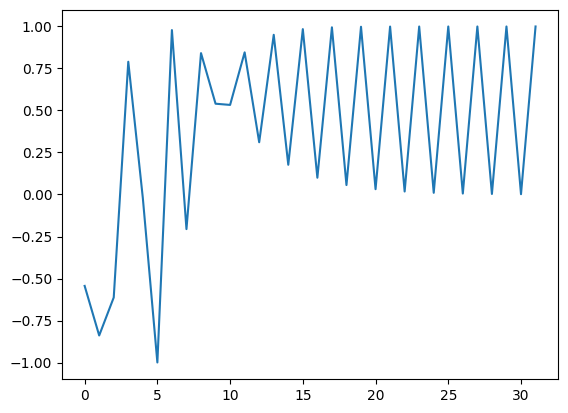

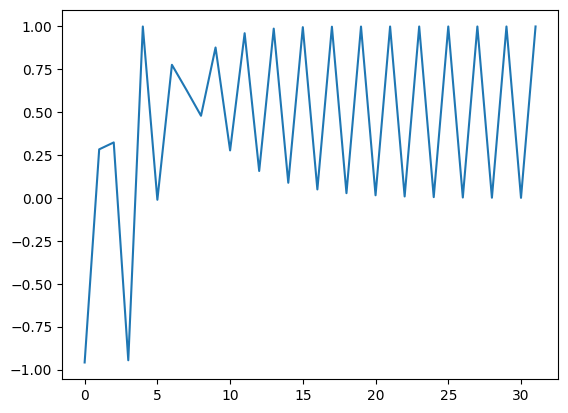

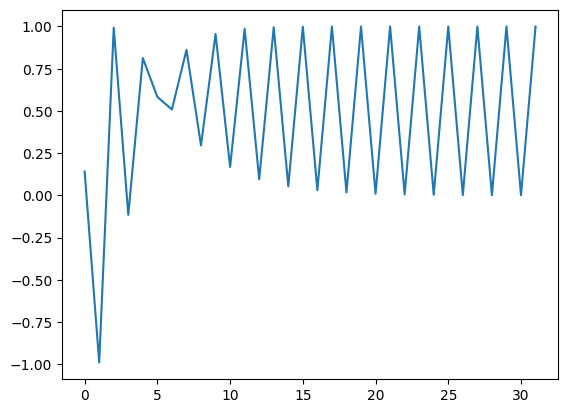

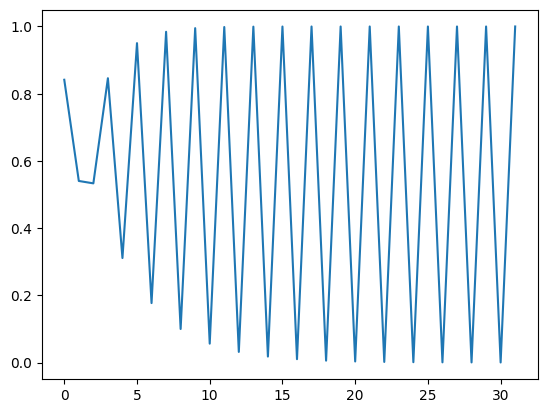

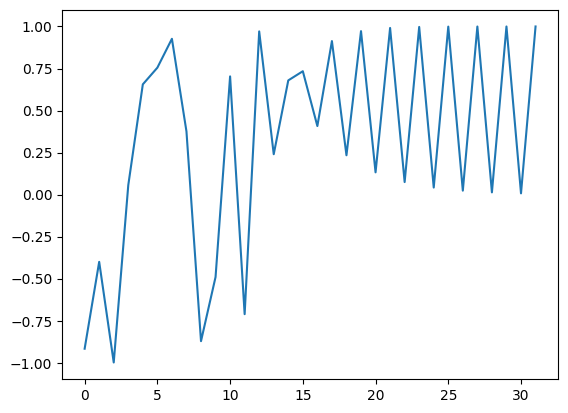

In [27]:
pos_enc_func = unet.pos_enc
print(pos_enc_func[torch.tensor([10,5,3,1,42]).long()].shape)
for fingerprint in pos_enc_func[torch.tensor([10,5,3,1,42]).long()]:
    plt.plot(fingerprint.cpu())
    plt.show()

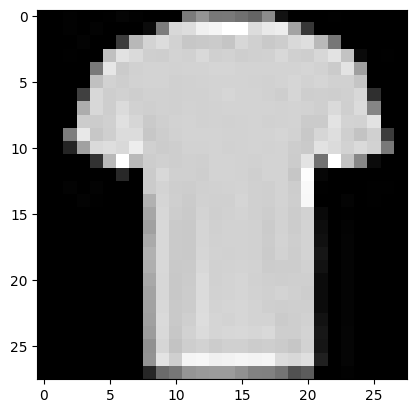

In [28]:
plt.imshow(i[0, 0, :, :].cpu(), cmap='gray')
plt.show()


In [29]:
learning_rate = 0.002
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=learning_rate, weight_decay = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, verbose=True)

def evaluate(net, dataloader, device):
    net.eval()
    num_val_batches = len(dataloader)
    

    
    progress_bar = tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False)
    for batch in progress_bar:
        image, mask_true = batch[0], batch[1]

            # move images and labels to correct device and type
        image = image.to(dtype=torch.float32, memory_format=torch.channels_last).cpu()
        noisy_image, eps, anzahl_schritte = mache_noise_direkt_random(image)
        mask_true = mask_true.to(dtype=torch.long)
        
        mask_pred = net(noisy_image, anzahl_schritte).to(device)
        
        loss = criterion(mask_pred, eps)
        
        


    net.train()
    return 

In [30]:
#unet = torch.load('best_fmnist_model_vol2.pt')
#unet.eval()

In [31]:
def train_model(
        model,
        device,
        epochs: int = 0,
        learning_rate: float = 1e-2,
        val_percent: float = 0.1,
        img_scale: float = 0.5,
        weight_decay: float = 1e-8,
        gradient_clipping: float = 1.0,
):
    
    min_loss = 1e25
    progress_bar = tqdm(range(epochs), total=epochs, position=0, leave=True)
    for epoch in progress_bar:
        mean_epoch_loss = []
        model.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            image, mask_true = [t.to(device) for t in data]
            progress_bar.set_postfix({f'T of {[len(trainloader)]}' : i+1, 'Best loss': min_loss}, refresh=True)
            optimizer.zero_grad()
                # move images and labels to correct device and type
            image = image.to(dtype=torch.float32, memory_format=torch.channels_last)
            noisy_image, eps, anzahl_schritte = mache_noise_direkt_random(image)
            mask_true = mask_true.to(dtype=torch.long)

            mask_pred = model(noisy_image, anzahl_schritte).to(device)

            loss = criterion(mask_pred, eps)
            mean_epoch_loss.append(loss.item())

            loss.backward()
            optimizer.step()
            
            
            running_loss += loss.item()
        
        loss_mean = np.mean(mean_epoch_loss)
        # scheduler on loss_mean with patience 10 with more aggressive learning rate
        scheduler.step(loss_mean)
        if loss_mean < min_loss:
            min_loss = loss_mean
            #torch.save(model, 'fmnist_model_latent.pt')
        if epoch%100==0:
            print('---')
            print(f"Epoch: {epoch} | Train Loss: {loss_mean} | Best Loss: {min_loss}")

                
    evaluate(model, valloader, device) 


In [32]:
train_model(unet, device)

0it [00:00, ?it/s]
Validation round:   0%|                                                                                                                                                                  | 0/40 [00:00<?, ?batch/s]/tmp/ipykernel_233722/1524519049.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_quer = torch.tensor(alpha_quer, dtype=torch.float32).to(device)  # 'device' is your CUDA device


In [33]:
def try_to_revert(noise, eps, anzahl_schritte, total_schritte=1000):
    alpha_quers = berechne_alpha_quer_x_forward_steps(total_schritte)
    return (noise - eps * np.sqrt(1-alpha_quers[anzahl_schritte - 1]))/np.sqrt(alpha_quers[anzahl_schritte - 1])


In [34]:
unet = torch.load('best_fmnist_model_vol2.pt')
unet.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(33, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNor

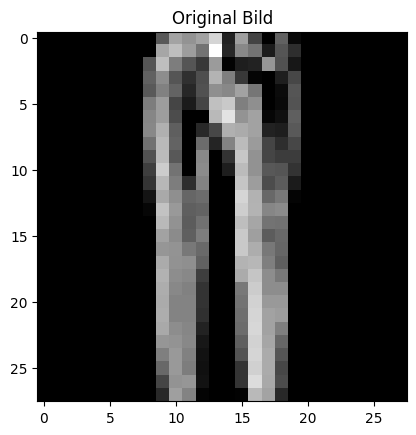

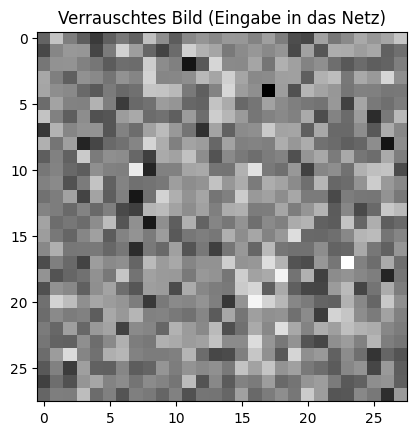

torch.Size([1, 1, 28, 28])


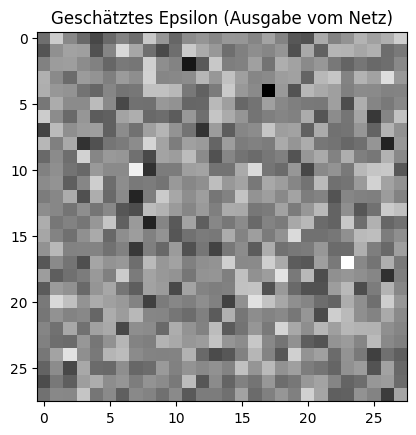

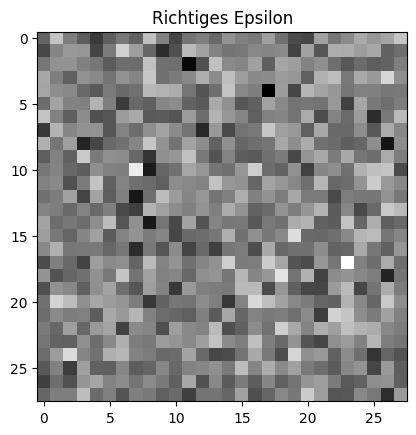

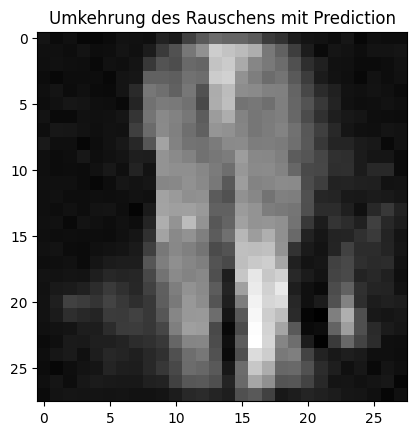

In [90]:
dataiter = iter(trainloader)
i, data = next(dataiter)
t_zahl = 400

plt.imshow(i[0,0].cpu().detach().numpy(), cmap="gray")
plt.title("Original Bild")
plt.show()

img_noise, eps = mache_noise_direkt(i[0:1].to(device), t_zahl)

plt.imshow(img_noise[0,0].cpu().detach().numpy(), cmap="gray")
plt.title("Verrauschtes Bild (Eingabe in das Netz)")
plt.show()
print(img_noise.shape)
img_pred = unet(img_noise, t_zahl)



plt.imshow(img_pred[0,0].cpu().detach().numpy(), cmap="gray")
plt.title("Geschätztes Epsilon (Ausgabe vom Netz)")
plt.show()



plt.imshow(eps[0,0].cpu().detach().numpy(), cmap="gray")
plt.title("Richtiges Epsilon")
plt.show()

reverted_img = try_to_revert(img_noise, img_pred, t_zahl)

plt.imshow(reverted_img[0,0].cpu().detach().numpy(), cmap="gray")
plt.title("Umkehrung des Rauschens mit Prediction")
plt.show()

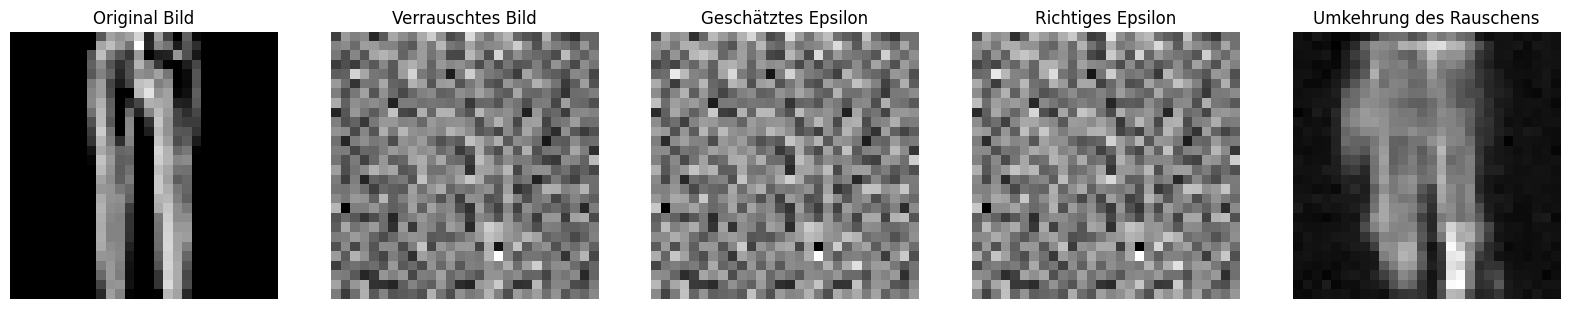

In [91]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # 1 Reihe, 5 Spalten

# Original Bild
axs[0].imshow(i[0, 0].cpu().detach().numpy(), cmap="gray")
axs[0].set_title("Original Bild")
axs[0].axis('off')

# Verrauschtes Bild
img_noise, eps = mache_noise_direkt(i[0:1].to(device), t_zahl)
axs[1].imshow(img_noise[0, 0].cpu().detach().numpy(), cmap="gray")
axs[1].set_title("Verrauschtes Bild")
axs[1].axis('off')

# Geschätztes Epsilon
img_pred = unet(img_noise, t_zahl)
axs[2].imshow(img_pred[0, 0].cpu().detach().numpy(), cmap="gray")
axs[2].set_title("Geschätztes Epsilon")
axs[2].axis('off')

# Richtiges Epsilon
axs[3].imshow(eps[0, 0].cpu().detach().numpy(), cmap="gray")
axs[3].set_title("Richtiges Epsilon")
axs[3].axis('off')

# Naive Umkehrung des Rauschens
reverted_img = try_to_revert(img_noise, img_pred, t_zahl)
axs[4].imshow(reverted_img[0, 0].cpu().detach().numpy(), cmap="gray")
axs[4].set_title("Umkehrung des Rauschens")
axs[4].axis('off')

plt.show()


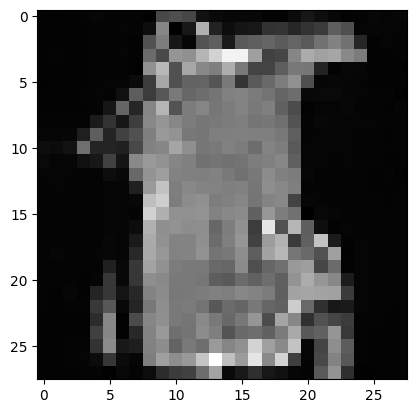

In [38]:
from IPython.display import display, clear_output

betas = create_linear_schedule(1000, 0.0001, 0.02)
alphas = 1 - np.array(betas)
alphas_quer = []
for k in range(len(alphas)):
    alphas_quer.append(np.prod(alphas[:k + 1]))

img_noise, eps = mache_noise_direkt(i[0:1].to(device), 1000)
img_noise = torch.randn_like(img_noise)
fig, ax = plt.subplots()

for j in reversed(range(999)):    
    img_pred = unet(img_noise, j)
    if j > 1:
        z = torch.randn_like(img_noise)
    else:
        z = torch.zeros_like(img_noise)
    #ausführliche Definition von Sigma:   
    #img_noise = (1/np.sqrt(alphas[j+1])) * (img_noise - ((1- alphas[j+1])/(np.sqrt(1-alphas_quer[j+1]))) * img_pred) + np.sqrt((1-alphas_quer[j])/(1-alphas_quer[j+1]) *betas[j+1])*z
    #Sigma^2 = beta:
    # Alter Ansatz: DDPM
    img_noise = (1/np.sqrt(alphas[j+1])) * (img_noise - ((1- alphas[j+1])/(np.sqrt(1-alphas_quer[j+1]))) * img_pred) + np.sqrt(betas[j+1])*z
    
    
    if j % 100 == 0:
        clear_output(wait=True)  # Löscht die vorherige Ausgabe
        plt.imshow(img_noise[0,0].cpu().detach().numpy(), cmap="gray")
        plt.show()


In [39]:
resnet = torch.load("Fashion_MNIST_Res_Noise.pt")
resnet.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv2): Conv2d(256, 64, ker

In [85]:
from IPython.display import display, clear_output
coole_generierte_bilder = []

def wir_generieren_gerne_bilder():
    coole_generierte_bilder.clear()
    betas = create_linear_schedule(1000, 0.0001, 0.02)
    alphas = 1 - np.array(betas)
    alphas_quer = []
    for k in range(len(alphas)):
        alphas_quer.append(np.prod(alphas[:k + 1]))

    img_noise, eps = mache_noise_direkt(i[0:1].to(device), 1000)
    img_noise = torch.randn_like(img_noise)
    fig, ax = plt.subplots()
    label = -10
    scale = 5
    resnet.requires_grad_(False)
    for j in reversed(range(999)):
        with torch.no_grad():
            img_pred = unet(img_noise, j)
        if j < 1000:
            img_noise.requires_grad_(requires_grad=True)
            img_noise.grad = torch.zeros_like(img_noise)
            out = resnet(img_noise)
            log_out = torch.log(out[0,label])
            log_out.backward(retain_graph=True)
            dummer_gradient = img_noise.grad
        #ausführliche Definition von Sigma:   
        #img_noise = (1/np.sqrt(alphas[j+1])) * (img_noise - ((1- alphas[j+1])/(np.sqrt(1-alphas_quer[j+1]))) * img_pred) + np.sqrt((1-alphas_quer[j])/(1-alphas_quer[j+1]) *betas[j+1])*z
        #Sigma^2 = beta:
            with torch.no_grad():
                z = torch.randn_like(img_noise)
                eps_hat = img_pred - (np.sqrt(1-alphas_quer[j+1])) * scale * dummer_gradient
                #img_noise = np.sqrt(alphas_quer[j]) * ((img_noise - (np.sqrt(1 - alphas_quer[j + 1]) * eps_hat) / np.sqrt(alphas_quer[j + 1]))) + np.sqrt(1 - alphas_quer[j]) * eps_hat
                img_noise = (1/np.sqrt(alphas[j+1])) * (img_noise - ((1- alphas[j+1])/(np.sqrt(1-alphas_quer[j+1]))) * eps_hat) + np.sqrt(betas[j+1])*z
                if j%50 == 0:
                    coole_generierte_bilder.append(img_noise)
        else:
            z = torch.randn_like(img_noise)
            img_noise = (1/np.sqrt(alphas[j+1])) * (img_noise - ((1- alphas[j+1])/(np.sqrt(1-alphas_quer[j+1]))) * img_pred) + np.sqrt(betas[j+1])*z

        if j % 100 == 0:
            #print(dummer_gradient.min(), dummer_gradient.max(), dummer_gradient.mean(), dummer_gradient.std())
            clear_output(wait=True)  # Löscht die vorherige Ausgabe
            plt.imshow(img_noise[0,0].cpu().detach().numpy(), cmap="gray")
            plt.show()
    
    return img_noise
        

In [86]:
def ich_checke_gerne_ob_richtig():
    label = 0
    index = 0
    img_gen = wir_generieren_gerne_bilder()
    pred = resnet(img_gen)
    for g in range(10):
        if dataset_train.classes[g] == dataset_valid.classes[pred.argmax().cpu()]:
            index = g
    if index == label:
        print("Vallah gut!")
    else:
        ich_checke_gerne_ob_richtig()
        

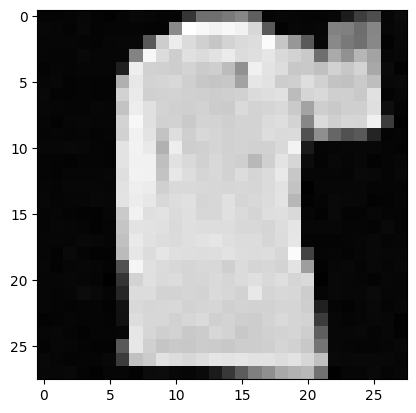

Vallah gut!


In [88]:
ich_checke_gerne_ob_richtig()

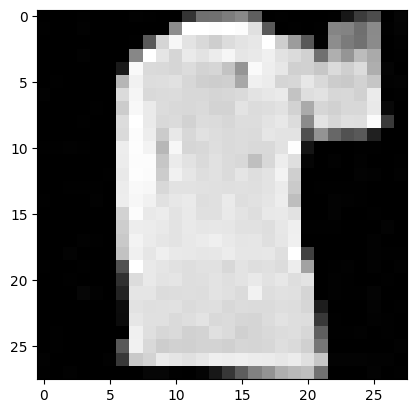

In [89]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()

for m in range(10):
    coole_generierte_bilder.append(coole_generierte_bilder[-1])
# Ihr Array coole_generierte_bilder
# Beispiel: coole_generierte_bilder = [np.random.rand(100, 100) for _ in range(10)]

im = ax.imshow(coole_generierte_bilder[0].cpu().detach().numpy()[0,0], cmap='gray', vmin=-1, vmax=1)

def update(num):
    im.set_array(coole_generierte_bilder[num].cpu().detach().numpy()[0,0])
    return im,

ani = animation.FuncAnimation(fig, update, frames=range(len(coole_generierte_bilder)), blit=True)

ani.save('animation.gif', writer='pillow')
